# Multivariable Forecasting Methods 

#### Importing the important variables

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.seasonal import STL

from pmdarima.model_selection import train_test_split as time_train_test_split
from pmdarima import auto_arima

from sklearn import metrics
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from prophet.plot import plot_plotly, plot_components_plotly
from prophet import Prophet

from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

#### Defining main functions 

In [2]:
def mean_absolute_percentage_error_func(y_true, y_pred):
    '''
    Calculate the mean absolute percentage error as a metric for evaluation
    '''    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
        
    print('Metric Results: ')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred).round(2)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred).round(2)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred)).round(2)}')

In [4]:
def Augmented_Dickey_Fuller_Test_func(timeseries , column_name):
 
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    adfTest = adfuller(timeseries, autolag='AIC')
    dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
    for key, value in adfTest[4].items():
       dfResults['Critical Value (%s)'%key] = value
    print (dfResults)
    if adfTest[1] <= 0.05:
        print()
        print("Conclusion:")
        print("Reject the null hypothesis")
        print('\033[92m' + "Data is stationary" + '\033[0m')
    else:
        print()
        print("Conclusion:")
        print("Fail to reject the null hypothesis")
        print('\033[91m' + "Data is non-stationary" + '\033[0m')

In [5]:
def inverse_diff_func(actual_df, pred_df):
    
    df_temp = pred_df.copy()
    columns = actual_df.columns
    for col in columns: 
        df_temp[str(col)+'_inv_diff'] = actual_df[col].iloc[-1] + df_temp[str(col)].cumsum()
    return df_temp

#### Reading Data-Set

In [6]:
def parser(s):
    return datetime.strptime(s, '%m/%d/%Y')

In [7]:
df = pd.read_csv('Scaled_sales_Mansfield_WH_SW_Alto_2022.final.1.csv', parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

# Features Engineering

### Standardize Variables 

In [8]:
num_cols = df [[
    
    'PPI_ConcreteProducts_lag3', 
    'PPI_ConstructionMaterials_lag3', 
    'All_EmployeesConstruction_lag3', 
    'HomesUSA_lag3', 
    'UnemploymentRate_lag3', 
    'JobOpenConstruction_lag3'
    
]]

scaler = StandardScaler()

#for loop
for col in num_cols:
    df[col] = scaler.fit_transform(df[[col]])

<AxesSubplot:>

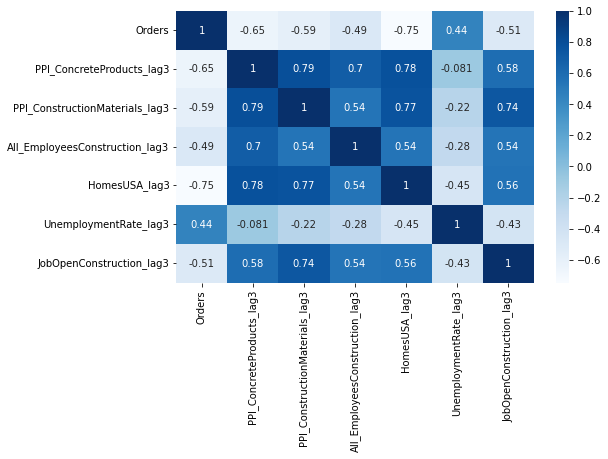

In [9]:
plt.figure(figsize=(8, 5))
sns.heatmap(df.corr(), cmap='Blues', annot=True)

### Plotting all variables 

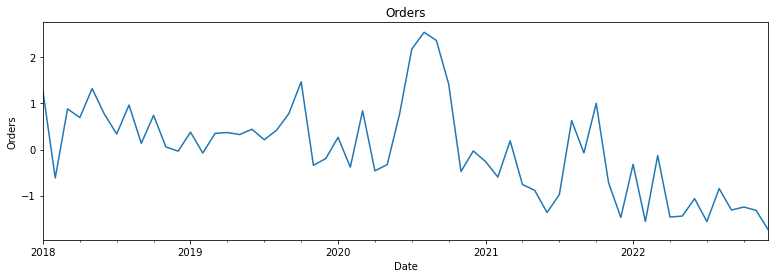

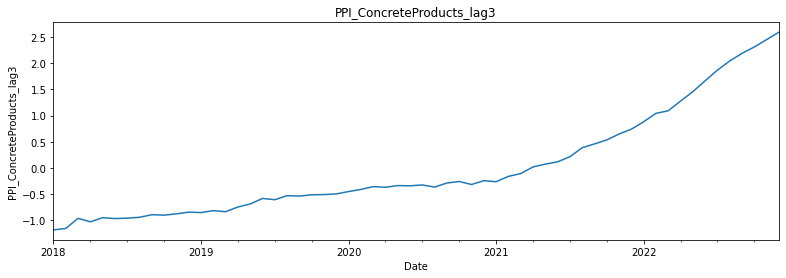

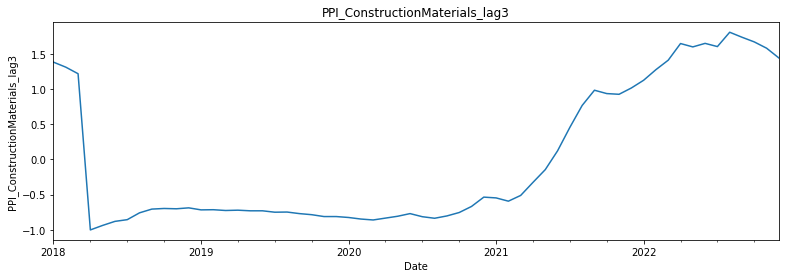

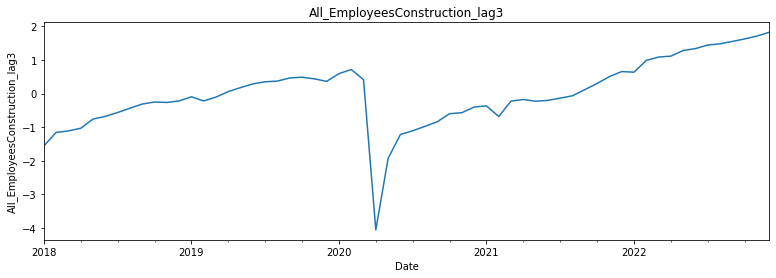

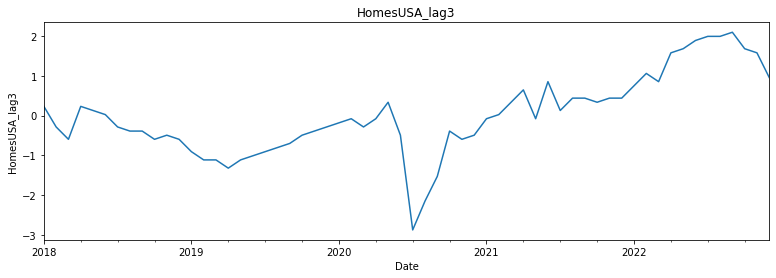

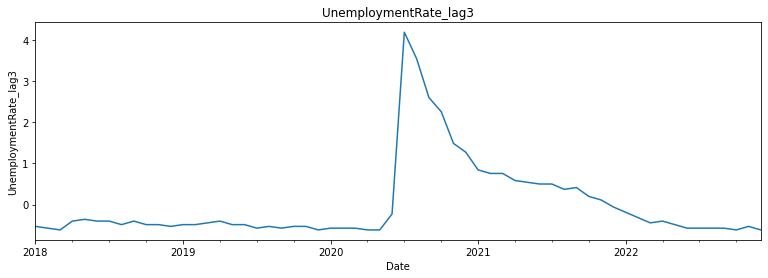

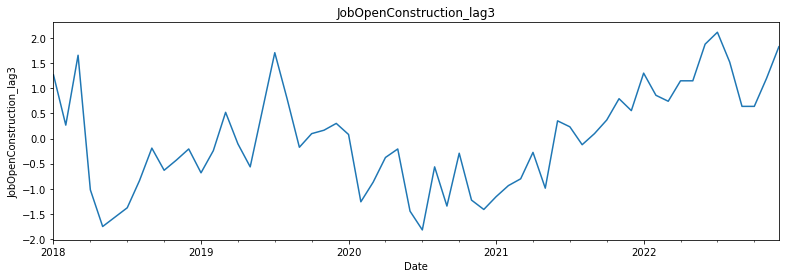

In [10]:
for feature in df[['Orders', 'PPI_ConcreteProducts_lag3', 'PPI_ConstructionMaterials_lag3', 'All_EmployeesConstruction_lag3', 'HomesUSA_lag3', 'UnemploymentRate_lag3', 'JobOpenConstruction_lag3']]:
       
    df[str(feature)].plot(figsize=(13, 4))
    plt.xlabel("Date")
    plt.ylabel(feature)
    plt.title(f"{str(feature)}")
    plt.show()

### Orders Seasonal Decompose

In [11]:
orders_series = df.Orders

stl = STL(orders_series)
result = stl.fit()

seasonal, trend, resid = result.seasonal, result.trend, result.resid

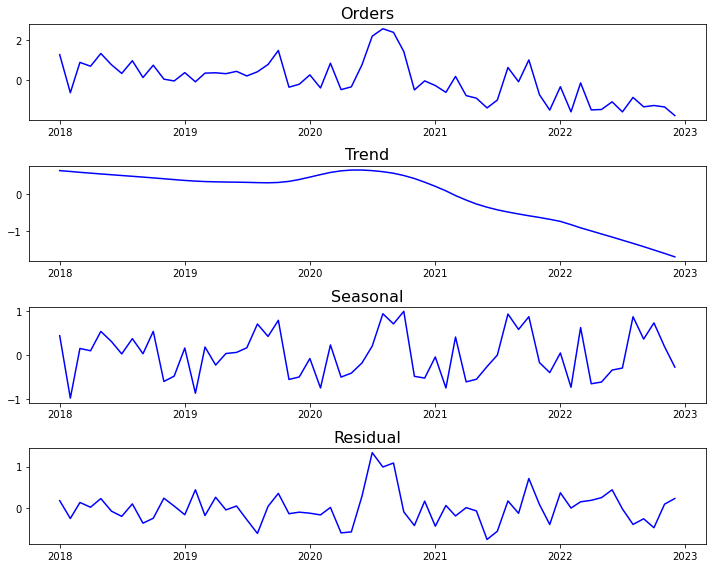

In [12]:
plt.figure(figsize=(10,8))

plt.subplot(4,1,1)
plt.plot(orders_series, color='blue')
plt.title('Orders', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend, color='blue')
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal, color='blue')
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid, color='blue')
plt.title('Residual', fontsize=16)

plt.tight_layout()

### Transforming all variables 

In [13]:
#Remove Increasing Volatility
orders_series = df.Orders
annual_volatility = orders_series.groupby(orders_series.index.year).std()
orders_annual_vol = orders_series.index.map(lambda d: annual_volatility.loc[d.year])
orders_series = orders_series / orders_annual_vol

#Remove Seasonality
month_avgs = orders_series.groupby(orders_series.index.month).mean()
orders_month_avg = orders_series.index.map(lambda d: month_avgs.loc[d.month])
orders_series = orders_series - orders_month_avg


In [14]:
#Remove Increasing Volatility
Concrete_series = df.PPI_ConcreteProducts_lag3
Concrete_annual_volatility = Concrete_series.groupby(Concrete_series.index.year).std()
Concrete_annual_vol = Concrete_series.index.map(lambda d: Concrete_annual_volatility.loc[d.year])
Concrete_series = Concrete_series / Concrete_annual_vol

#Remove Seasonality
month_avgs1 = Concrete_series.groupby(Concrete_series.index.month).mean()
Concrete_month_avg = Concrete_series.index.map(lambda d: month_avgs1.loc[d.month])
Concrete_series = Concrete_series - Concrete_month_avg

In [15]:
#Remove Increasing Volatility
Construction_series = df.PPI_ConstructionMaterials_lag3
Construction_annual_volatility = Construction_series.groupby(Construction_series.index.year).std()
Construction_annual_vol = Construction_series.index.map(lambda d: Construction_annual_volatility.loc[d.year])
Construction_series = Construction_series / Construction_annual_vol

#Remove Seasonality
month_avgs2 = Construction_series.groupby(Construction_series.index.month).mean()
Construction_month_avg = Construction_series.index.map(lambda d: month_avgs2.loc[d.month])
Construction_series = Construction_series - Construction_month_avg


In [16]:
#Remove Increasing Volatility
Employees_series = df.All_EmployeesConstruction_lag3
Employees_annual_volatility = Employees_series.groupby(Employees_series.index.year).std()
Employees_annual_vol = Employees_series.index.map(lambda d: Employees_annual_volatility.loc[d.year])
Employees_series = Employees_series / Employees_annual_vol

#Remove Seasonality
month_avgs3 = Employees_series.groupby(Employees_series.index.month).mean()
Employees_month_avg = Employees_series.index.map(lambda d: month_avgs3.loc[d.month])
Employees_series = Employees_series - Employees_month_avg

In [17]:
#Remove Increasing Volatility
HomesUSA_series = df.HomesUSA_lag3  
HomesUSA_annual_volatility = HomesUSA_series.groupby(HomesUSA_series.index.year).std()
HomesUSA_annual_vol = HomesUSA_series.index.map(lambda d: HomesUSA_annual_volatility.loc[d.year])
HomesUSA_series = HomesUSA_series  / HomesUSA_annual_vol

#Remove Seasonality
month_avgs4 = HomesUSA_series.groupby(HomesUSA_series.index.month).mean()
HomesUSA__month_avg = HomesUSA_series.index.map(lambda d: month_avgs4.loc[d.month])
HomesUSA_series = HomesUSA_series - HomesUSA__month_avg

In [18]:
#Remove Increasing Volatility
Unemployment_series = df.UnemploymentRate_lag3
Unemploymen_annual_volatility = Unemployment_series.groupby(Unemployment_series.index.year).std()
Unemploymen_annual_vol = Unemployment_series.index.map(lambda d: Unemploymen_annual_volatility.loc[d.year])
Unemploymen_series = Unemployment_series / Unemploymen_annual_vol 

#Remove Seasonality
month_avgs5 = Unemploymen_series.groupby(Unemploymen_series.index.month).mean()
Unemploymen_month_avg = Unemploymen_series.index.map(lambda d: month_avgs5.loc[d.month])
Unemploymen_series = Unemploymen_series - Unemploymen_month_avg

In [19]:
#Remove Increasing Volatility
JobOpen_series = df.JobOpenConstruction_lag3
JobOpen_annual_volatility = JobOpen_series.groupby(JobOpen_series.index.year).std()
JobOpen_annual_vol = JobOpen_series.index.map(lambda d: JobOpen_annual_volatility.loc[d.year])
JobOpen_series = JobOpen_series / JobOpen_annual_vol

#Remove Seasonality
month_avgs6 = JobOpen_series.groupby(JobOpen_series.index.month).mean()
JobOpen_month_avg = JobOpen_series.index.map(lambda d: month_avgs6.loc[d.month])
JobOpen_series = JobOpen_series - JobOpen_month_avg

### Replacing the Transforming Data into a Dataframe

In [20]:
df['Orders'] = orders_series
df['PPI_ConcreteProducts_lag3'] = Concrete_series
df['PPI_ConstructionMaterials_lag3'] = Construction_series
df['All_EmployeesConstruction_lag3'] = Employees_series
df['HomesUSA_lag3'] = HomesUSA_series
df['UnemploymentRate_lag3'] = Unemploymen_series 
df['JobOpenConstruction_lag3'] = JobOpen_series

### Plotting the Transformation Data 

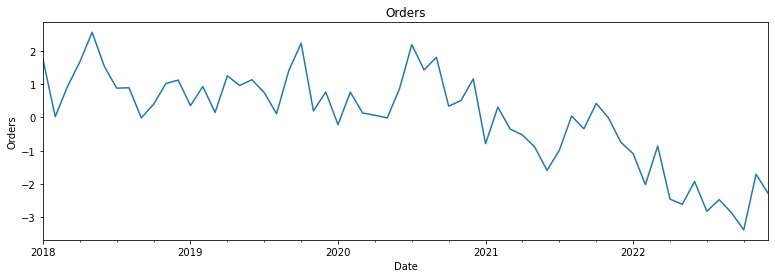

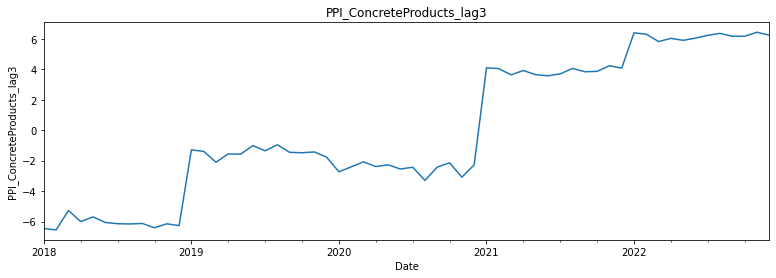

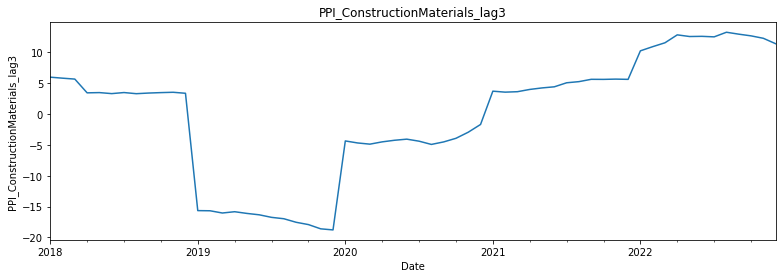

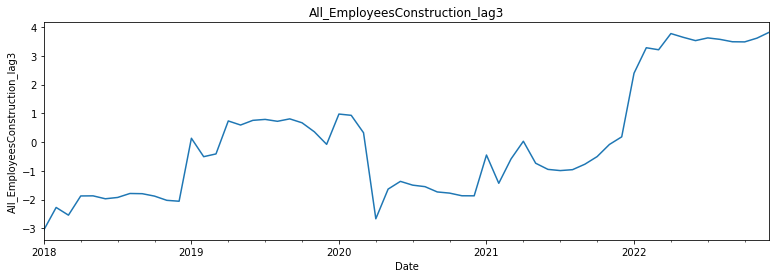

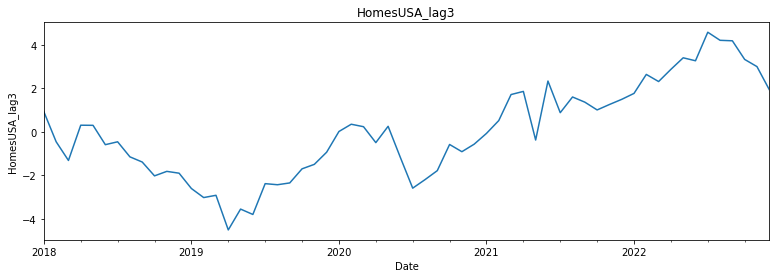

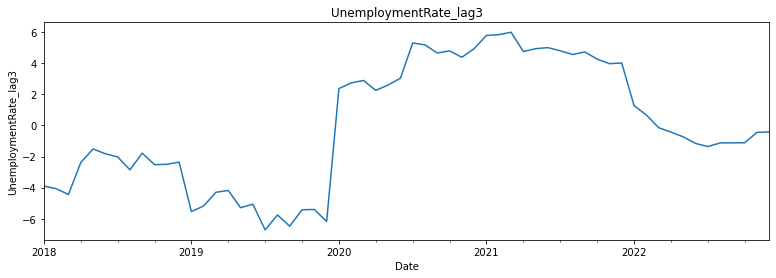

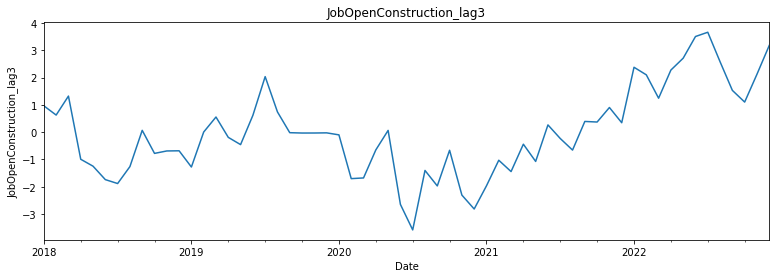

In [21]:
for feature in df[['Orders', 'PPI_ConcreteProducts_lag3', 'PPI_ConstructionMaterials_lag3', 'All_EmployeesConstruction_lag3', 'HomesUSA_lag3', 'UnemploymentRate_lag3', 'JobOpenConstruction_lag3']]:
       
    df[str(feature)].plot(figsize=(13, 4))
    plt.xlabel("Date")
    plt.ylabel(feature)
    plt.title(f"{str(feature)}")
    plt.show()

### Check for stationary

In [22]:
for name, column in df[['Orders',  'PPI_ConcreteProducts_lag3', 'PPI_ConstructionMaterials_lag3', 'All_EmployeesConstruction_lag3', 'HomesUSA_lag3', 'UnemploymentRate_lag3', 'JobOpenConstruction_lag3']].iteritems():
    Augmented_Dickey_Fuller_Test_func(df[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: Orders
ADF Test Statistic      -1.252082
P-Value                  0.650800
# Lags Used              1.000000
# Observations Used     58.000000
Critical Value (1%)     -3.548494
Critical Value (5%)     -2.912837
Critical Value (10%)    -2.594129
dtype: float64

Conclusion:
Fail to reject the null hypothesis
Data is non-stationary


Results of Dickey-Fuller Test for column: PPI_ConcreteProducts_lag3
ADF Test Statistic      -1.027518
P-Value                  0.743096
# Lags Used              0.000000
# Observations Used     59.000000
Critical Value (1%)     -3.546395
Critical Value (5%)     -2.911939
Critical Value (10%)    -2.593652
dtype: float64

Conclusion:
Fail to reject the null hypothesis
Data is non-stationary


Results of Dickey-Fuller Test for column: PPI_ConstructionMaterials_lag3
ADF Test Statistic      -1.075014
P-Value                  0.724933
# Lags Used              0.000000
# Observations Used     59.000000
Critical Value (1%)   

  # Multivariate Time Series Models 

## 1. Linear Regression Model

In [23]:
x = df[['PPI_ConcreteProducts_lag3', 'PPI_ConstructionMaterials_lag3', 'All_EmployeesConstruction_lag3', 'HomesUSA_lag3', 'UnemploymentRate_lag3', 'JobOpenConstruction_lag3']]
y = df[['Orders']]

In [24]:
# Train Test Split 
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [25]:
X_train.shape

(48, 6)

In [26]:
X_test.shape

(12, 6)

In [27]:
# Fit the model 
model1 = LinearRegression()
model1.fit(X_train, y_train)

LinearRegression()

In [28]:
# Get prediction 
y_pred_train = model1.predict(X_train)
y_pred_test= model1.predict(X_test)

In [29]:
print('TRAINING SET')
timeseries_evaluation_metrics_func(y_train, y_pred_train)

TRAINING SET
Metric Results: 
MSE is : 0.4
MAE is : 0.5
RMSE is : 0.63


In [30]:
print('TESTING SET')
timeseries_evaluation_metrics_func(y_test, y_pred_test)

TESTING SET
Metric Results: 
MSE is : 0.41
MAE is : 0.55
RMSE is : 0.64


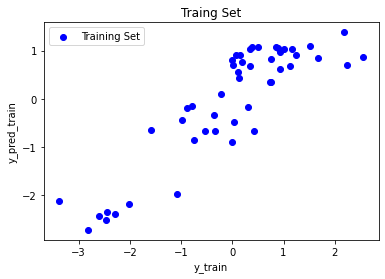

In [31]:
plt.scatter(y_train, y_pred_train, color="blue", label="Training Set")
plt.title ('Traing Set')
plt.ylabel('y_pred_train')
plt.xlabel('y_train')
plt.legend()
plt.show()

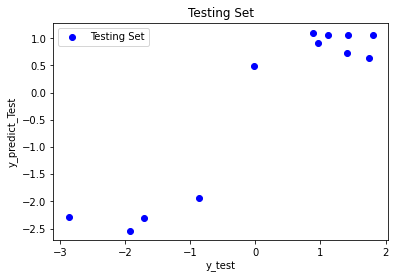

In [32]:
plt.scatter(y_test, y_pred_test, color="blue", label="Testing Set")
plt.title ('Testing Set')
plt.ylabel('y_predict_Test')
plt.xlabel('y_test')
plt.legend()
plt.show()

### Plotting Prediction

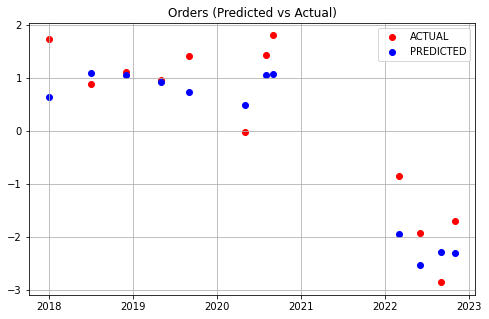

In [33]:
plt.figure(figsize=(8, 5))
handles = ['ACTUAL' , 'PREDICTED']
plt.scatter(y_test.index, y_test, c= "red", )
plt.scatter(y_test.index, y_pred_test, c= "blue")
plt.title("Orders (Predicted vs Actual)")
plt.legend(handles)
plt.grid(True)

In [34]:
coef = model1.coef_

In [35]:
coef1 = coef.reshape(6)

In [36]:
coef1 

array([-0.08346398, -0.0305933 , -0.1862116 , -0.09427376, -0.01066373,
       -0.17853995])

In [37]:
df_cols = list(x.columns)

In [38]:
df_cols

['PPI_ConcreteProducts_lag3',
 'PPI_ConstructionMaterials_lag3',
 'All_EmployeesConstruction_lag3',
 'HomesUSA_lag3',
 'UnemploymentRate_lag3',
 'JobOpenConstruction_lag3']

In [39]:
df_cols1 = np.array(df_cols)

In [40]:
df_cols1.reshape(6)

array(['PPI_ConcreteProducts_lag3', 'PPI_ConstructionMaterials_lag3',
       'All_EmployeesConstruction_lag3', 'HomesUSA_lag3',
       'UnemploymentRate_lag3', 'JobOpenConstruction_lag3'], dtype='<U30')

In [41]:
df_coef = pd.DataFrame({'Features':df_cols1, 'Coefficients':coef1})
df_coef

,Features,Coefficients
0,PPI_ConcreteProducts_lag3,-0.083464
1,PPI_ConstructionMaterials_lag3,-0.030593
2,All_EmployeesConstruction_lag3,-0.186212
3,HomesUSA_lag3,-0.094274
4,UnemploymentRate_lag3,-0.010664
5,JobOpenConstruction_lag3,-0.178540


### Prediction for the next 3 months 

In [42]:
df_new = pd.read_csv('newdata.csv', parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

In [43]:
df_new

,Orders,PPI_ConcreteProducts_lag3,PPI_ConstructionMaterials_lag3,All_EmployeesConstruction_lag3,HomesUSA_lag3,UnemploymentRate_lag3,JobOpenConstruction_lag3
Date,,,,,,,
2023-01-01,-1.249637,343.900,333.769,7814,103,3.7,390
2023-02-01,-1.321594,347.344,330.548,7833,98,3.6,331
2023-03-01,-1.747332,350.787,326.320,7859,95,3.5,413


In [44]:
df_new_1 = df_new[['PPI_ConcreteProducts_lag3', 'PPI_ConstructionMaterials_lag3', 'All_EmployeesConstruction_lag3', 'HomesUSA_lag3', 'UnemploymentRate_lag3', 'JobOpenConstruction_lag3']] 

In [45]:
num_cols = df_new_1[[
    
    'PPI_ConcreteProducts_lag3', 
    'PPI_ConstructionMaterials_lag3', 
    'All_EmployeesConstruction_lag3', 
    'HomesUSA_lag3', 
    'UnemploymentRate_lag3', 
    'JobOpenConstruction_lag3'
    
]]

scaler = StandardScaler()

#for loop
for col in num_cols:
    df_new_1[col] = scaler.fit_transform(df_new_1[[col]])

In [46]:
df_new_1

,PPI_ConcreteProducts_lag3,PPI_ConstructionMaterials_lag3,All_EmployeesConstruction_lag3,HomesUSA_lag3,UnemploymentRate_lag3,JobOpenConstruction_lag3
Date,,,,,,
2023-01-01,-1.224804,1.166009,-1.156585,1.313198,1.224745,0.347474
2023-02-01,0.000119,0.110044,-0.126501,-0.202031,0.000000,-1.360938
2023-03-01,1.224686,-1.276054,1.283086,-1.111168,-1.224745,1.013464


In [47]:
# Getting future prediction 

y_pred_new= model1.predict(df_new_1)
y_pred_new

array([[ 0.01679667],
       [ 0.21597813],
       [-0.43146287]])

In [48]:
y_pred_new = y_pred_new.reshape(3)

In [49]:
df_forecast = pd.DataFrame({'Date':df_new.index, 'Orders_Future':y_pred_new})
df_forecast

,Date,Orders_Future
0,2023-01-01,0.016797
1,2023-02-01,0.215978
2,2023-03-01,-0.431463


### Plotting Future Data 

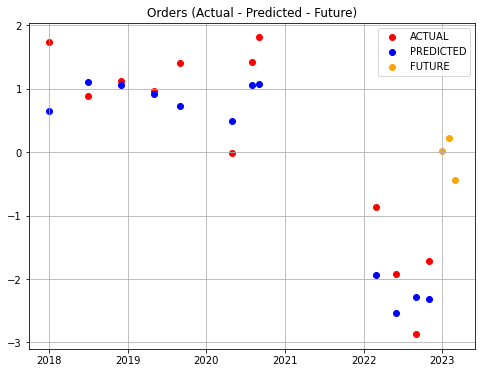

In [50]:
plt.figure(figsize=(8, 6))
handles = ['ACTUAL' , 'PREDICTED', 'FUTURE']
plt.scatter(y_test.index, y_test, c= "red", )
plt.scatter(y_test.index, y_pred_test, c="blue")
plt.scatter(df_new_1.index, y_pred_new, c="orange")
plt.title("Orders (Actual - Predicted - Future)")
plt.legend(handles)
plt.grid(True)

## 2.Vector Autoregression (VAR)

###  Train Test Split

In [51]:
trainX = df[:57]
testX = df[57:]

###  Make data stationary

In [52]:
train_diff = trainX.diff()
train_diff.dropna(inplace = True)

### Check again for stationary

In [53]:
for name, column in train_diff.iteritems():
    Augmented_Dickey_Fuller_Test_func(train_diff[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: Orders
ADF Test Statistic     -1.133539e+01
P-Value                 1.086922e-20
# Lags Used             0.000000e+00
# Observations Used     5.500000e+01
Critical Value (1%)    -3.555273e+00
Critical Value (5%)    -2.915731e+00
Critical Value (10%)   -2.595670e+00
dtype: float64

Conclusion:
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: PPI_ConcreteProducts_lag3
ADF Test Statistic     -6.210783e+00
P-Value                 5.514493e-08
# Lags Used             1.000000e+00
# Observations Used     5.400000e+01
Critical Value (1%)    -3.557709e+00
Critical Value (5%)    -2.916770e+00
Critical Value (10%)   -2.596222e+00
dtype: float64

Conclusion:
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: PPI_ConstructionMaterials_lag3
ADF Test Statistic     -7.183712e+00
P-Value                 2.609632e-10
# Lags Used             0.000000e+00
# Observations Used     5.500

#### Get best AR Terms

In [54]:
resu = []
df_results_VAR = pd.DataFrame()

for i in [1,2,3,4]:
    fit_v = VAR(train_diff).fit(i)
    aic = fit_v.aic
    bic = fit_v.bic
    df1 = {'AR_Term':i, 'AIC': aic, 'BIC': bic}
    df_results_VAR = df_results_VAR.append(df1, ignore_index=True)
    clist = ['AR_Term','AIC','BIC']
    df_results_VAR = df_results_VAR[clist]  

In [55]:
df_results_VAR.sort_values(by=['AIC', 'BIC'], ascending=True)

,AR_Term,AIC,BIC
2,3.0,1.510406,7.235406
0,1.0,1.575502,3.619332
3,4.0,1.854186,9.471541
1,2.0,2.600773,6.468242


In [56]:
best_values_VAR = df_results_VAR.sort_values(by=['AIC', 'BIC']).head(1)
best_values_VAR

,AR_Term,AIC,BIC
2,3.0,1.510406,7.235406


In [57]:
AR_Term_value_VAR = best_values_VAR['AR_Term'].iloc[0]

print("AR_Term_value_VAR: ", AR_Term_value_VAR)

AR_Term_value_VAR:  3.0


### Fit VAR

In [58]:
model = VAR(train_diff).fit(int(AR_Term_value_VAR))

result = model.forecast(y=train_diff.values, steps=len(testX))

In [59]:
df_pred = pd.DataFrame(result, columns=train_diff.columns)
df_pred["Date"] = testX.index
df_pred = df_pred.set_index("Date")
df_pred

,Orders,PPI_ConcreteProducts_lag3,PPI_ConstructionMaterials_lag3,All_EmployeesConstruction_lag3,HomesUSA_lag3,UnemploymentRate_lag3,JobOpenConstruction_lag3
Date,,,,,,,
2022-10-01,0.213845,0.914790,1.601324,0.237472,-0.259442,1.197762,0.284076
2022-11-01,-0.396074,0.691389,1.164070,0.235497,0.208756,0.658775,0.844885
2022-12-01,0.103108,0.227468,-1.120636,-0.152995,0.271338,-0.139551,-0.210294


###  Inverse Transformation

In [60]:
res = inverse_diff_func(trainX, df_pred)
res

,Orders,PPI_ConcreteProducts_lag3,PPI_ConstructionMaterials_lag3,All_EmployeesConstruction_lag3,HomesUSA_lag3,UnemploymentRate_lag3,JobOpenConstruction_lag3,Orders_inv_diff,PPI_ConcreteProducts_lag3_inv_diff,PPI_ConstructionMaterials_lag3_inv_diff,All_EmployeesConstruction_lag3_inv_diff,HomesUSA_lag3_inv_diff,UnemploymentRate_lag3_inv_diff,JobOpenConstruction_lag3_inv_diff
Date,,,,,,,,,,,,,,
2022-10-01,0.213845,0.914790,1.601324,0.237472,-0.259442,1.197762,0.284076,-2.652245,7.082732,14.570598,3.730312,3.918939,0.078454,1.816302
2022-11-01,-0.396074,0.691389,1.164070,0.235497,0.208756,0.658775,0.844885,-3.048319,7.774121,15.734667,3.965809,4.127695,0.737229,2.661187
2022-12-01,0.103108,0.227468,-1.120636,-0.152995,0.271338,-0.139551,-0.210294,-2.945210,8.001589,14.614032,3.812814,4.399033,0.597678,2.450893


### VAR Evaluation

In [61]:
print('ORDERS EVALUATION')
timeseries_evaluation_metrics_func(testX['Orders'] , res['Orders'+'_inv_diff'])

ORDERS EVALUATION
Metric Results: 
MSE is : 0.92
MAE is : 0.91
RMSE is : 0.96


### Plotting VAR Results

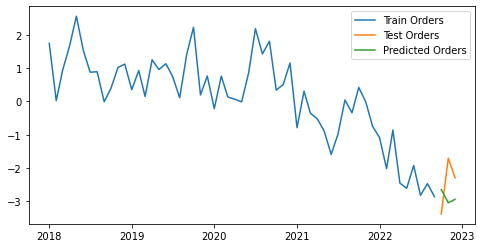

In [62]:
plt.rcParams["figure.figsize"] = [8,4]
plt.plot(trainX['Orders'], label='Train Orders')
plt.plot(testX['Orders'], label='Test Orders')
plt.plot(res['Orders_inv_diff'], label='Predicted Orders')
plt.legend(loc='best')
plt.show()

### Future Prediction

In [63]:
df_new

,Orders,PPI_ConcreteProducts_lag3,PPI_ConstructionMaterials_lag3,All_EmployeesConstruction_lag3,HomesUSA_lag3,UnemploymentRate_lag3,JobOpenConstruction_lag3
Date,,,,,,,
2023-01-01,-1.249637,343.900,333.769,7814,103,3.7,390
2023-02-01,-1.321594,347.344,330.548,7833,98,3.6,331
2023-03-01,-1.747332,350.787,326.320,7859,95,3.5,413


In [64]:
# Taking the whole data frame 
trainX1 = df

# Makig all data statinary 
train_diff1 = trainX1.diff()
train_diff1.dropna(inplace = True)

In [65]:
# Fit the model 
model = VAR(train_diff1).fit(int(AR_Term_value_VAR))

result1 = model.forecast(y=train_diff1.values, steps=3)

In [66]:
result1

array([[ 0.40324869, -0.0977431 , -5.8981079 , -0.30061781,  0.2981162 ,
        -2.6067484 , -0.51637987],
       [-0.21223598, -0.26368886,  0.9774674 ,  0.2591485 , -0.34276399,
        -0.29992544,  0.62588167],
       [ 0.11489916,  0.11993635, -0.31061009,  0.30750761, -0.09715769,
        -0.20454604, -0.46831798]])

In [67]:
df_pred_new = pd.DataFrame(result1, columns=train_diff1.columns)
df_pred_new["Date"] = df_new.index
df_pred_new = df_pred_new.set_index("Date")
df_pred_new

,Orders,PPI_ConcreteProducts_lag3,PPI_ConstructionMaterials_lag3,All_EmployeesConstruction_lag3,HomesUSA_lag3,UnemploymentRate_lag3,JobOpenConstruction_lag3
Date,,,,,,,
2023-01-01,0.403249,-0.097743,-5.898108,-0.300618,0.298116,-2.606748,-0.516380
2023-02-01,-0.212236,-0.263689,0.977467,0.259149,-0.342764,-0.299925,0.625882
2023-03-01,0.114899,0.119936,-0.310610,0.307508,-0.097158,-0.204546,-0.468318


In [68]:
res1 = inverse_diff_func(trainX1, df_pred_new)
res1

,Orders,PPI_ConcreteProducts_lag3,PPI_ConstructionMaterials_lag3,All_EmployeesConstruction_lag3,HomesUSA_lag3,UnemploymentRate_lag3,JobOpenConstruction_lag3,Orders_inv_diff,PPI_ConcreteProducts_lag3_inv_diff,PPI_ConstructionMaterials_lag3_inv_diff,All_EmployeesConstruction_lag3_inv_diff,HomesUSA_lag3_inv_diff,UnemploymentRate_lag3_inv_diff,JobOpenConstruction_lag3_inv_diff
Date,,,,,,,,,,,,,,
2023-01-01,0.403249,-0.097743,-5.898108,-0.300618,0.298116,-2.606748,-0.516380,-1.893141,6.141492,5.522545,3.523371,2.233723,-3.024776,2.664845
2023-02-01,-0.212236,-0.263689,0.977467,0.259149,-0.342764,-0.299925,0.625882,-2.105377,5.877803,6.500012,3.782520,1.890959,-3.324702,3.290726
2023-03-01,0.114899,0.119936,-0.310610,0.307508,-0.097158,-0.204546,-0.468318,-1.990478,5.997739,6.189402,4.090027,1.793801,-3.529248,2.822408


In [69]:
df_result = res1['Orders_inv_diff']
df_result

Date
2023-01-01   -1.893141
2023-02-01   -2.105377
2023-03-01   -1.990478
Name: Orders_inv_diff, dtype: float64

In [70]:
# Evaluate the model with the future prediction 

print('ORDERS EVALUATION')
timeseries_evaluation_metrics_func(df_new['Orders'] , res1['Orders'+'_inv_diff'])

ORDERS EVALUATION
Metric Results: 
MSE is : 0.36
MAE is : 0.56
RMSE is : 0.6


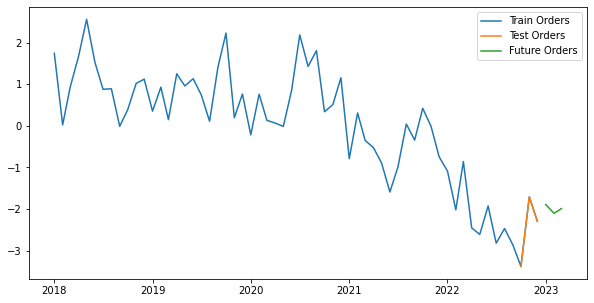

In [71]:
# Plotting Future data

plt.rcParams["figure.figsize"] = [10,5]
plt.plot(trainX1['Orders'], label='Train Orders')
plt.plot(testX['Orders'], label='Test Orders')
plt.plot(res1['Orders_inv_diff'], label='Future Orders')
plt.legend(loc='best')
plt.show()

# VARMA MODEL

### Get best p, q and tr Terms

In [72]:
param_grid = {'p': [1,2,3], 'q':[1,2,3], 'tr': ['n','c','t','ct']}
pg = list(ParameterGrid(param_grid))

In [73]:
df_results_VARMA = pd.DataFrame(columns=['p', 'q', 'tr','RMSE Orders','RMSE PPI_ConcreteProducts_lag3','RMSE PPI_ConstructionMaterials_lag3','RMSE All_EmployeesConstruction_lag3','RMSE HomesUSA_lag3', 'RMSE UnemploymentRate_lag3', 'RMSE JobOpenConstruction_lag3'])


for a,b in enumerate(pg):
    print(f' Running for {b}')
    p = b.get('p')
    q = b.get('q')
    tr = b.get('tr')
    model = VARMAX(train_diff, order=(p,q), trend=tr).fit()
    result = model.forecast(steps=len(testX))
    inv_res = inverse_diff_func(trainX, result)
    
    x1rmse = np.sqrt(metrics.mean_squared_error(testX.Orders, inv_res.Orders_inv_diff))
    x2rmse = np.sqrt(metrics.mean_squared_error(testX.PPI_ConcreteProducts_lag3, inv_res.PPI_ConcreteProducts_lag3_inv_diff))
    x3rmse = np.sqrt(metrics.mean_squared_error(testX.PPI_ConstructionMaterials_lag3, inv_res.PPI_ConstructionMaterials_lag3_inv_diff))
    x4rmse = np.sqrt(metrics.mean_squared_error(testX.All_EmployeesConstruction_lag3, inv_res.All_EmployeesConstruction_lag3_inv_diff))
    x5rmse = np.sqrt(metrics.mean_squared_error(testX.HomesUSA_lag3, inv_res.HomesUSA_lag3_inv_diff))
    x6rmse = np.sqrt(metrics.mean_squared_error(testX.UnemploymentRate_lag3, inv_res.UnemploymentRate_lag3_inv_diff))
    x7rmse = np.sqrt(metrics.mean_squared_error(testX.JobOpenConstruction_lag3, inv_res.JobOpenConstruction_lag3_inv_diff))
   
    
    df_results_VARMA = df_results_VARMA.append({'p': p, 'q': q, 'tr': tr,'RMSE Orders': x1rmse,
                                                'RMSE PPI_ConcreteProducts_lag3':x2rmse,'RMSE PPI_ConstructionMaterials_lag3':x3rmse,
                                                'RMSE All_EmployeesConstruction_lag3':x4rmse,'RMSE HomesUSA_lag3':x5rmse, 
                                                'RMSE UnemploymentRate_lag3': x6rmse, 'RMSE JobOpenConstruction_lag3': x7rmse }, ignore_index=True)
    
    
    

 Running for {'p': 1, 'q': 1, 'tr': 'n'}
 Running for {'p': 1, 'q': 1, 'tr': 'c'}
 Running for {'p': 1, 'q': 1, 'tr': 't'}
 Running for {'p': 1, 'q': 1, 'tr': 'ct'}
 Running for {'p': 1, 'q': 2, 'tr': 'n'}
 Running for {'p': 1, 'q': 2, 'tr': 'c'}
 Running for {'p': 1, 'q': 2, 'tr': 't'}
 Running for {'p': 1, 'q': 2, 'tr': 'ct'}
 Running for {'p': 1, 'q': 3, 'tr': 'n'}
 Running for {'p': 1, 'q': 3, 'tr': 'c'}
 Running for {'p': 1, 'q': 3, 'tr': 't'}
 Running for {'p': 1, 'q': 3, 'tr': 'ct'}
 Running for {'p': 2, 'q': 1, 'tr': 'n'}
 Running for {'p': 2, 'q': 1, 'tr': 'c'}
 Running for {'p': 2, 'q': 1, 'tr': 't'}
 Running for {'p': 2, 'q': 1, 'tr': 'ct'}
 Running for {'p': 2, 'q': 2, 'tr': 'n'}
 Running for {'p': 2, 'q': 2, 'tr': 'c'}
 Running for {'p': 2, 'q': 2, 'tr': 't'}
 Running for {'p': 2, 'q': 2, 'tr': 'ct'}
 Running for {'p': 2, 'q': 3, 'tr': 'n'}
 Running for {'p': 2, 'q': 3, 'tr': 'c'}
 Running for {'p': 2, 'q': 3, 'tr': 't'}
 Running for {'p': 2, 'q': 3, 'tr': 'ct'}
 Running f

In [74]:
df_results_VARMA.sort_values(by=['RMSE Orders','RMSE PPI_ConcreteProducts_lag3','RMSE PPI_ConstructionMaterials_lag3','RMSE All_EmployeesConstruction_lag3','RMSE HomesUSA_lag3', 'RMSE UnemploymentRate_lag3', 'RMSE JobOpenConstruction_lag3']).head()

,p,q,tr,RMSE Orders,RMSE PPI_ConcreteProducts_lag3,RMSE PPI_ConstructionMaterials_lag3,RMSE All_EmployeesConstruction_lag3,RMSE HomesUSA_lag3,RMSE UnemploymentRate_lag3,RMSE JobOpenConstruction_lag3
17,2,2,c,0.672564,0.515417,5.718072,0.5115,1.213455,1.345292,1.350091
16,2,2,n,0.695986,0.396724,5.905346,0.699328,1.307581,0.673872,1.22886
8,1,3,n,0.761032,0.54568,2.606043,0.153589,1.360277,0.370843,0.711408
12,2,1,n,0.839331,0.20434,2.060547,0.779113,1.236254,0.185019,0.870814
13,2,1,c,0.866256,0.629074,1.995684,0.507178,1.366324,0.435128,0.952398


In [75]:
best_values_VARMA = df_results_VARMA.sort_values(by=['RMSE Orders','RMSE PPI_ConcreteProducts_lag3','RMSE PPI_ConstructionMaterials_lag3','RMSE All_EmployeesConstruction_lag3','RMSE HomesUSA_lag3', 'RMSE UnemploymentRate_lag3', 'RMSE JobOpenConstruction_lag3']).head(1)
best_values_VARMA

,p,q,tr,RMSE Orders,RMSE PPI_ConcreteProducts_lag3,RMSE PPI_ConstructionMaterials_lag3,RMSE All_EmployeesConstruction_lag3,RMSE HomesUSA_lag3,RMSE UnemploymentRate_lag3,RMSE JobOpenConstruction_lag3
17,2,2,c,0.672564,0.515417,5.718072,0.5115,1.213455,1.345292,1.350091


In [76]:
p_value_VARMA = best_values_VARMA['p'].iloc[0]
q_value_VARMA = best_values_VARMA['q'].iloc[0] 
tr_value_VARMA = best_values_VARMA['tr'].iloc[0] 

print("p_value_VARMA: ", p_value_VARMA)
print("q_value_VARMA: ", q_value_VARMA)
print("tr_value_VARMA: ", tr_value_VARMA)

p_value_VARMA:  2
q_value_VARMA:  2
tr_value_VARMA:  c


### Fit VARMA

In [77]:
model = VARMAX(train_diff, 
               order=(p_value_VARMA, q_value_VARMA),trends = tr_value_VARMA).fit(disp=False)
result = model.forecast(steps = len(testX))

In [78]:
df_pred = pd.DataFrame(result, columns=train_diff.columns)
df_pred["Date"] = testX.index
df_pred = df_pred.set_index("Date")
df_pred

,Orders,PPI_ConcreteProducts_lag3,PPI_ConstructionMaterials_lag3,All_EmployeesConstruction_lag3,HomesUSA_lag3,UnemploymentRate_lag3,JobOpenConstruction_lag3
Date,,,,,,,
2022-10-01,0.002797,0.397368,2.844648,-0.449727,-0.191619,0.823611,-0.094070
2022-11-01,0.117703,0.247057,2.714872,0.097504,-0.293003,1.284192,0.367810
2022-12-01,0.557776,0.131392,-0.068063,0.084609,0.108290,0.236570,-0.917163


### Inverse Transformation

In [79]:
res = inverse_diff_func(trainX, df_pred)
res.head()

,Orders,PPI_ConcreteProducts_lag3,PPI_ConstructionMaterials_lag3,All_EmployeesConstruction_lag3,HomesUSA_lag3,UnemploymentRate_lag3,JobOpenConstruction_lag3,Orders_inv_diff,PPI_ConcreteProducts_lag3_inv_diff,PPI_ConstructionMaterials_lag3_inv_diff,All_EmployeesConstruction_lag3_inv_diff,HomesUSA_lag3_inv_diff,UnemploymentRate_lag3_inv_diff,JobOpenConstruction_lag3_inv_diff
Date,,,,,,,,,,,,,,
2022-10-01,0.002797,0.397368,2.844648,-0.449727,-0.191619,0.823611,-0.094070,-2.863292,6.565311,15.813922,3.043113,3.986763,-0.295697,1.438156
2022-11-01,0.117703,0.247057,2.714872,0.097504,-0.293003,1.284192,0.367810,-2.745590,6.812367,18.528794,3.140617,3.693760,0.988495,1.805966
2022-12-01,0.557776,0.131392,-0.068063,0.084609,0.108290,0.236570,-0.917163,-2.187814,6.943760,18.460731,3.225226,3.802049,1.225065,0.888803


### Evaluation of VARMA

In [80]:
print('ORDERS EVALUATION')
timeseries_evaluation_metrics_func(testX['Orders'] , res['Orders'+'_inv_diff'])

ORDERS EVALUATION
Metric Results: 
MSE is : 0.45
MAE is : 0.56
RMSE is : 0.67


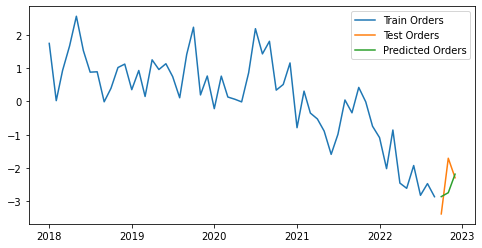

In [81]:
plt.rcParams["figure.figsize"] = [8,4]
plt.plot(trainX['Orders'], label='Train Orders')
plt.plot(testX['Orders'], label='Test Orders')
plt.plot(res['Orders_inv_diff'], label='Predicted Orders')
plt.legend(loc='best')
plt.show()

### Future Prediction 

In [82]:
model = VARMAX(train_diff1, 
               order=(p_value_VARMA, q_value_VARMA),trends = tr_value_VARMA).fit(disp=False)
result1 = model.forecast(steps = 3)

In [83]:
df_pred_new = pd.DataFrame(result1, columns=train_diff.columns)
df_pred_new["Date"] = df_new.index
df_pred_new = df_pred_new.set_index("Date")
df_pred_new

,Orders,PPI_ConcreteProducts_lag3,PPI_ConstructionMaterials_lag3,All_EmployeesConstruction_lag3,HomesUSA_lag3,UnemploymentRate_lag3,JobOpenConstruction_lag3
Date,,,,,,,
2023-01-01,0.187874,0.185669,-4.734599,-0.329178,0.105344,-1.551645,-0.753031
2023-02-01,-0.237776,0.449869,0.300504,0.865087,0.047104,-0.089095,1.456028
2023-03-01,0.049723,-0.166181,-2.363125,0.218461,-0.104579,-0.439697,-0.788684


In [84]:
res1 = inverse_diff_func(trainX, df_pred_new)
res1

,Orders,PPI_ConcreteProducts_lag3,PPI_ConstructionMaterials_lag3,All_EmployeesConstruction_lag3,HomesUSA_lag3,UnemploymentRate_lag3,JobOpenConstruction_lag3,Orders_inv_diff,PPI_ConcreteProducts_lag3_inv_diff,PPI_ConstructionMaterials_lag3_inv_diff,All_EmployeesConstruction_lag3_inv_diff,HomesUSA_lag3_inv_diff,UnemploymentRate_lag3_inv_diff,JobOpenConstruction_lag3_inv_diff
Date,,,,,,,,,,,,,,
2023-01-01,0.187874,0.185669,-4.734599,-0.329178,0.105344,-1.551645,-0.753031,-2.678216,6.353612,8.234674,3.163662,4.283726,-2.670953,0.779195
2023-02-01,-0.237776,0.449869,0.300504,0.865087,0.047104,-0.089095,1.456028,-2.915992,6.803480,8.535179,4.028749,4.330830,-2.760047,2.235223
2023-03-01,0.049723,-0.166181,-2.363125,0.218461,-0.104579,-0.439697,-0.788684,-2.866269,6.637300,6.172054,4.247209,4.226251,-3.199744,1.446539


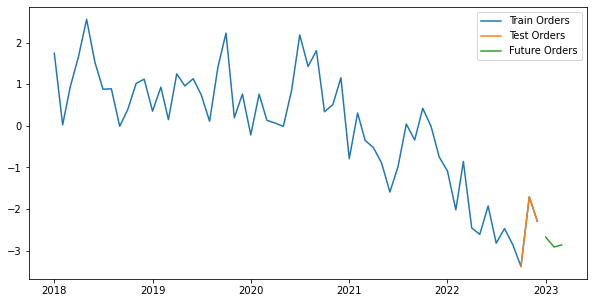

In [85]:
plt.rcParams["figure.figsize"] = [10,5]
plt.plot(trainX1['Orders'], label='Train Orders')
plt.plot(testX['Orders'], label='Test Orders')
plt.plot(res1['Orders_inv_diff'], label='Future Orders')
plt.legend(loc='best')
plt.show()

In [86]:
result = res1['Orders_inv_diff']

In [87]:
result

Date
2023-01-01   -2.678216
2023-02-01   -2.915992
2023-03-01   -2.866269
Name: Orders_inv_diff, dtype: float64

##  VARMA with Auto Arima

In [88]:
pq = []
for name, column in train_diff[['Orders','PPI_ConcreteProducts_lag3','PPI_ConstructionMaterials_lag3','All_EmployeesConstruction_lag3','HomesUSA_lag3', 'UnemploymentRate_lag3', 'JobOpenConstruction_lag3']].iteritems():
    print(f'Searching order of p and q for : {name}')
    stepwise_model = auto_arima(train_diff[name],start_p=1, start_q=1,max_p=7, max_q=7, seasonal=False,
        trace=True,error_action='ignore',suppress_warnings=True, stepwise=True,maxiter=1000)
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : Orders
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=137.929, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=144.643, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=137.660, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=136.061, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=137.991, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=139.819, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=136.140, Time=0.01 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.083 seconds
optimal order for:Orders is: (0, 0, 1) 


Searching order of p and q for : PPI_ConcreteProducts_lag3
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=185.083, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=181.325, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=183.313, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=183.

In [89]:
pq

[(0, 0, 1), (0, 0, 0), (0, 0, 0), (0, 0, 0), (1, 0, 0), (0, 0, 0), (0, 0, 2)]

In [90]:
df_results_VARMA_2 = pd.DataFrame(columns=['p', 'q','RMSE Orders','RMSE PPI_ConcreteProducts_lag3','RMSE PPI_ConstructionMaterials_lag3','RMSE All_EmployeesConstruction_lag3','RMSE HomesUSA_lag3', 'RMSE UnemploymentRate_lag3', 'RMSE JobOpenConstruction_lag3'])

for i in pq:
    if i[0]== 0 and i[2] ==0:
        pass
    else:
        print(f' Running for {i}')
        model = VARMAX(train_diff, order=(i[0],i[2])).fit(disp=False)
        result = model.forecast(steps = len(testX))
        inv_res = inverse_diff_func(trainX, result)
        
        x1rmse = np.sqrt(metrics.mean_squared_error(testX.Orders, inv_res.Orders_inv_diff))
        x2rmse = np.sqrt(metrics.mean_squared_error(testX.PPI_ConcreteProducts_lag3, inv_res.PPI_ConcreteProducts_lag3_inv_diff))
        x3rmse = np.sqrt(metrics.mean_squared_error(testX.PPI_ConstructionMaterials_lag3, inv_res.PPI_ConstructionMaterials_lag3_inv_diff))
        x4rmse = np.sqrt(metrics.mean_squared_error(testX.All_EmployeesConstruction_lag3, inv_res.All_EmployeesConstruction_lag3_inv_diff))
        x5rmse = np.sqrt(metrics.mean_squared_error(testX.HomesUSA_lag3, inv_res.HomesUSA_lag3_inv_diff))
        x6rmse = np.sqrt(metrics.mean_squared_error(testX.UnemploymentRate_lag3, inv_res.UnemploymentRate_lag3_inv_diff))
        x7rmse = np.sqrt(metrics.mean_squared_error(testX.JobOpenConstruction_lag3, inv_res.JobOpenConstruction_lag3_inv_diff))
    
    
        
        df_results_VARMA_2 = df_results_VARMA_2.append({'p': i[0], 'q': i[2], 'RMSE Orders': x1rmse,
                                                'RMSE PPI_ConcreteProducts_lag3':x2rmse,'RMSE PPI_ConstructionMaterials_lag3':x3rmse,
                                                'RMSE All_EmployeesConstruction_lag3':x4rmse,'RMSE HomesUSA_lag3':x5rmse, 
                                                'RMSE UnemploymentRate_lag3': x6rmse, 'RMSE JobOpenConstruction_lag3': x7rmse}, ignore_index=True)
                

 Running for (0, 0, 1)
 Running for (1, 0, 0)
 Running for (0, 0, 2)


In [91]:
df_results_VARMA_2.sort_values(by=['RMSE Orders','RMSE PPI_ConcreteProducts_lag3','RMSE PPI_ConstructionMaterials_lag3','RMSE All_EmployeesConstruction_lag3','RMSE HomesUSA_lag3', 'RMSE UnemploymentRate_lag3', 'RMSE JobOpenConstruction_lag3'])

,p,q,RMSE Orders,RMSE PPI_ConcreteProducts_lag3,RMSE PPI_ConstructionMaterials_lag3,RMSE All_EmployeesConstruction_lag3,RMSE HomesUSA_lag3,RMSE UnemploymentRate_lag3,RMSE JobOpenConstruction_lag3
0,0.0,1.0,0.854336,1.186333,2.007046,0.258889,1.314155,0.382559,0.938277
2,0.0,2.0,0.856113,0.671998,2.669767,0.250339,1.788665,0.117487,0.637426
1,1.0,0.0,0.879481,0.538609,1.527748,0.052608,1.679729,0.40455,0.902411


In [92]:
best_values_VAR_2 = df_results_VARMA_2.sort_values(by=['RMSE Orders','RMSE PPI_ConcreteProducts_lag3','RMSE PPI_ConstructionMaterials_lag3','RMSE All_EmployeesConstruction_lag3','RMSE HomesUSA_lag3', 'RMSE UnemploymentRate_lag3', 'RMSE JobOpenConstruction_lag3']).head(1)
best_values_VAR_2

,p,q,RMSE Orders,RMSE PPI_ConcreteProducts_lag3,RMSE PPI_ConstructionMaterials_lag3,RMSE All_EmployeesConstruction_lag3,RMSE HomesUSA_lag3,RMSE UnemploymentRate_lag3,RMSE JobOpenConstruction_lag3
0,0.0,1.0,0.854336,1.186333,2.007046,0.258889,1.314155,0.382559,0.938277


In [93]:
p_value_VARMA_2 = best_values_VAR_2['p'].iloc[0]
q_value_VARMA_2 = best_values_VAR_2['q'].iloc[0] 

print("p_value_VARMA_2: ", p_value_VARMA_2)
print("q_value_VARMA_2: ", q_value_VARMA_2)

p_value_VARMA_2:  0.0
q_value_VARMA_2:  1.0


### Fit VARMA with Auto Arima

In [94]:
model = VARMAX(train_diff, 
               order=(int(p_value_VARMA_2),int(q_value_VARMA_2))).fit(disp=False)
result = model.forecast(steps = len(testX))

In [95]:
df_pred = pd.DataFrame(result, columns=train_diff.columns)
df_pred["Date"] = testX.index
df_pred = df_pred.set_index("Date")
df_pred

,Orders,PPI_ConcreteProducts_lag3,PPI_ConstructionMaterials_lag3,All_EmployeesConstruction_lag3,HomesUSA_lag3,UnemploymentRate_lag3,JobOpenConstruction_lag3
Date,,,,,,,
2022-10-01,0.033703,1.052049,0.981972,0.283617,-0.341191,0.665303,1.029243
2022-11-01,-0.070919,0.231090,0.098814,0.122693,0.061002,0.041255,0.042683
2022-12-01,-0.070919,0.231090,0.098814,0.122693,0.061002,0.041255,0.042683


### Inverse Transformation

In [96]:
res = inverse_diff_func(trainX, df_pred)
res.head()

,Orders,PPI_ConcreteProducts_lag3,PPI_ConstructionMaterials_lag3,All_EmployeesConstruction_lag3,HomesUSA_lag3,UnemploymentRate_lag3,JobOpenConstruction_lag3,Orders_inv_diff,PPI_ConcreteProducts_lag3_inv_diff,PPI_ConstructionMaterials_lag3_inv_diff,All_EmployeesConstruction_lag3_inv_diff,HomesUSA_lag3_inv_diff,UnemploymentRate_lag3_inv_diff,JobOpenConstruction_lag3_inv_diff
Date,,,,,,,,,,,,,,
2022-10-01,0.033703,1.052049,0.981972,0.283617,-0.341191,0.665303,1.029243,-2.832387,7.219992,13.951245,3.776457,3.837191,-0.454005,2.561469
2022-11-01,-0.070919,0.231090,0.098814,0.122693,0.061002,0.041255,0.042683,-2.903306,7.451082,14.050059,3.899150,3.898194,-0.412750,2.604153
2022-12-01,-0.070919,0.231090,0.098814,0.122693,0.061002,0.041255,0.042683,-2.974225,7.682172,14.148873,4.021842,3.959196,-0.371495,2.646836


### Evaluation of VARMA with Auto Arima

In [97]:
print('ORDERS EVALUATION')
timeseries_evaluation_metrics_func(testX['Orders'] , res['Orders'+'_inv_diff'])

ORDERS EVALUATION
Metric Results: 
MSE is : 0.73
MAE is : 0.81
RMSE is : 0.85


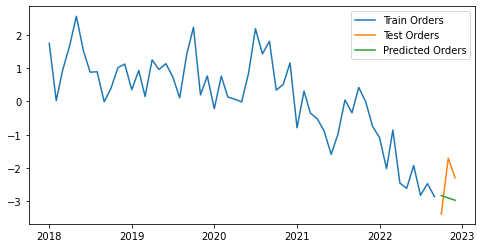

In [98]:
plt.rcParams["figure.figsize"] = [8,4]
plt.plot(trainX['Orders'], label='Train Orders')
plt.plot(testX['Orders'], label='Test Orders')
plt.plot(res['Orders_inv_diff'], label='Predicted Orders')
plt.legend(loc='best')
plt.show()

### Future Prediction 

In [99]:
model = VARMAX(train_diff1, 
               order=(int(p_value_VARMA_2),int(q_value_VARMA_2))).fit(disp=False)
result1 = model.forecast(steps = 3)

In [100]:
result1 

,Orders,PPI_ConcreteProducts_lag3,PPI_ConstructionMaterials_lag3,All_EmployeesConstruction_lag3,HomesUSA_lag3,UnemploymentRate_lag3,JobOpenConstruction_lag3
2023-01-01,-0.174975,-0.457678,-1.442517,0.380524,0.793903,-0.761937,-0.599895
2023-02-01,-0.065624,0.200236,0.026247,0.120621,0.036585,0.033429,0.034654
2023-03-01,-0.065624,0.200236,0.026247,0.120621,0.036585,0.033429,0.034654


In [101]:
df_pred_new = pd.DataFrame(result1, columns=train_diff.columns)
df_pred_new["Date"] = result1 .index
df_pred_new = df_pred_new.set_index("Date")
df_pred_new

,Orders,PPI_ConcreteProducts_lag3,PPI_ConstructionMaterials_lag3,All_EmployeesConstruction_lag3,HomesUSA_lag3,UnemploymentRate_lag3,JobOpenConstruction_lag3
Date,,,,,,,
2023-01-01,-0.174975,-0.457678,-1.442517,0.380524,0.793903,-0.761937,-0.599895
2023-02-01,-0.065624,0.200236,0.026247,0.120621,0.036585,0.033429,0.034654
2023-03-01,-0.065624,0.200236,0.026247,0.120621,0.036585,0.033429,0.034654


In [102]:
res1 = inverse_diff_func(trainX, df_pred_new)
res1

,Orders,PPI_ConcreteProducts_lag3,PPI_ConstructionMaterials_lag3,All_EmployeesConstruction_lag3,HomesUSA_lag3,UnemploymentRate_lag3,JobOpenConstruction_lag3,Orders_inv_diff,PPI_ConcreteProducts_lag3_inv_diff,PPI_ConstructionMaterials_lag3_inv_diff,All_EmployeesConstruction_lag3_inv_diff,HomesUSA_lag3_inv_diff,UnemploymentRate_lag3_inv_diff,JobOpenConstruction_lag3_inv_diff
Date,,,,,,,,,,,,,,
2023-01-01,-0.174975,-0.457678,-1.442517,0.380524,0.793903,-0.761937,-0.599895,-3.041065,5.710264,11.526756,3.873364,4.972284,-1.881245,0.932331
2023-02-01,-0.065624,0.200236,0.026247,0.120621,0.036585,0.033429,0.034654,-3.106690,5.910500,11.553003,3.993985,5.008869,-1.847816,0.966985
2023-03-01,-0.065624,0.200236,0.026247,0.120621,0.036585,0.033429,0.034654,-3.172314,6.110737,11.579250,4.114606,5.045454,-1.814387,1.001640


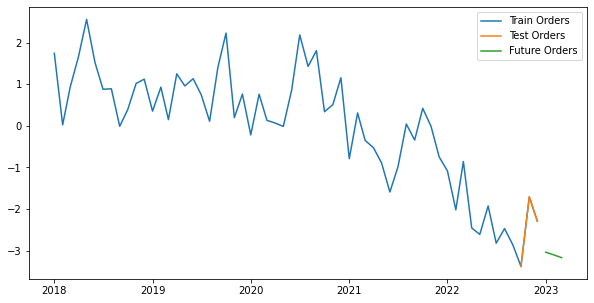

In [103]:
plt.rcParams["figure.figsize"] = [10,5]
plt.plot(trainX1['Orders'], label='Train Orders')
plt.plot(testX['Orders'], label='Test Orders')
plt.plot(res1['Orders_inv_diff'], label='Future Orders')
plt.legend(loc='best')
plt.show()

In [105]:
result = res1['Orders_inv_diff']
result

Date
2023-01-01   -3.041065
2023-02-01   -3.106690
2023-03-01   -3.172314
Name: Orders_inv_diff, dtype: float64

# Prophet Model

In [108]:
df

,Orders,PPI_ConcreteProducts_lag3,PPI_ConstructionMaterials_lag3,All_EmployeesConstruction_lag3,HomesUSA_lag3,UnemploymentRate_lag3,JobOpenConstruction_lag3
Date,,,,,,,
2018-01-01,1.744619,-6.461899,5.995754,-3.056856,0.918520,-3.897172,0.965768
2018-02-01,0.022657,-6.550396,5.832902,-2.274985,-0.461644,-4.066552,0.627348
2018-03-01,0.930678,-5.274551,5.684663,-2.542941,-1.321173,-4.444006,1.323210
2018-04-01,1.668403,-6.005438,3.454468,-1.874631,0.298516,-2.389460,-0.994360
2018-05-01,2.561186,-5.696039,3.493995,-1.870846,0.293139,-1.511652,-1.247893
2018-06-01,1.526738,-6.060220,3.329015,-1.972975,-0.595818,-1.820439,-1.740731
2018-07-01,0.879350,-6.143952,3.501987,-1.927037,-0.463779,-2.023954,-1.884438
2018-08-01,0.891091,-6.157580,3.317139,-1.788722,-1.155577,-2.855944,-1.262746
2018-09-01,-0.011660,-6.125375,3.420848,-1.795830,-1.393307,-1.783608,0.066539


In [109]:
df = df.reset_index()

### Rename the columns

In [111]:
df = df.rename(columns={'Date': 'ds', 'Orders': 'y', 'PPI_ConcreteProducts_lag3': 'y1', 'PPI_ConstructionMaterials_lag3':'y2', 'All_EmployeesConstruction_lag3':'y3', 'HomesUSA_lag3':'y4', 'UnemploymentRate_lag3': 'y5', 'JobOpenConstruction_lag3':'y6'})

In [112]:
df

,ds,y,y1,y2,y3,y4,y5,y6
0,2018-01-01,1.744619,-6.461899,5.995754,-3.056856,0.918520,-3.897172,0.965768
1,2018-02-01,0.022657,-6.550396,5.832902,-2.274985,-0.461644,-4.066552,0.627348
2,2018-03-01,0.930678,-5.274551,5.684663,-2.542941,-1.321173,-4.444006,1.323210
3,2018-04-01,1.668403,-6.005438,3.454468,-1.874631,0.298516,-2.389460,-0.994360
4,2018-05-01,2.561186,-5.696039,3.493995,-1.870846,0.293139,-1.511652,-1.247893
5,2018-06-01,1.526738,-6.060220,3.329015,-1.972975,-0.595818,-1.820439,-1.740731
6,2018-07-01,0.879350,-6.143952,3.501987,-1.927037,-0.463779,-2.023954,-1.884438
7,2018-08-01,0.891091,-6.157580,3.317139,-1.788722,-1.155577,-2.855944,-1.262746
8,2018-09-01,-0.011660,-6.125375,3.420848,-1.795830,-1.393307,-1.783608,0.066539
9,2018-10-01,0.393016,-6.407330,3.492402,-1.879973,-2.029279,-2.521347,-0.778795


### Create the model

In [113]:
model = Prophet()

### Add all variables to the model

In [114]:
model.add_regressor('y1')
model.add_regressor('y2')
model.add_regressor('y3')
model.add_regressor('y4')
model.add_regressor('y5')
model.add_regressor('y6')

### Fit the model to the train data

In [115]:
model_train = model.fit(df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### Make Future Prediction

In [130]:
future = model.make_future_dataframe(periods=4, freq='M')

### Add the variable2 column to the future dataframe

In [131]:
future['y']  = df['y']
future['y1'] = df['y1']
future['y2'] = df['y2']
future['y3'] = df['y3']
future['y4'] = df['y4']
future['y5'] = df['y5']
future['y6'] = df['y6']

In [132]:
future

,ds,y,y1,y2,y3,y4,y5,y6
0,2018-01-01,1.744619,-6.461899,5.995754,-3.056856,0.918520,-3.897172,0.965768
1,2018-02-01,0.022657,-6.550396,5.832902,-2.274985,-0.461644,-4.066552,0.627348
2,2018-03-01,0.930678,-5.274551,5.684663,-2.542941,-1.321173,-4.444006,1.323210
3,2018-04-01,1.668403,-6.005438,3.454468,-1.874631,0.298516,-2.389460,-0.994360
4,2018-05-01,2.561186,-5.696039,3.493995,-1.870846,0.293139,-1.511652,-1.247893
...,...,...,...,...,...,...,...,...
59,2022-12-01,-2.296390,6.239235,11.420653,3.823989,1.935607,-0.418028,3.181225
60,2022-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61,2023-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,2023-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [133]:
future1= future.fillna(0)

### Make predictions for the future data

In [134]:
forecast = model.predict(future1)

In [135]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(3)

,ds,yhat,yhat_lower,yhat_upper
61,2023-01-31,-1.941796,-2.730106,-1.186051
62,2023-02-28,-2.143435,-2.891358,-1.413425
63,2023-03-31,-0.820943,-1.547683,-0.073061


### Model Evaluaion

In [136]:
df_test = df[57:]

In [137]:
df_test

,ds,y,y1,y2,y3,y4,y5,y6
57,2022-10-01,-3.383498,6.169756,12.694447,3.487980,3.322313,-1.114107,1.103717
58,2022-11-01,-1.708950,6.432704,12.300212,3.618604,2.992105,-0.446735,2.124072
59,2022-12-01,-2.296390,6.239235,11.420653,3.823989,1.935607,-0.418028,3.181225


In [138]:
df_forecast = forecast[57:60]

In [139]:
df_forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,...,y6,y6_lower,y6_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
57,2022-10-01,-1.341903,-2.935985,-1.459732,-1.341903,-1.341903,-0.807067,-0.807067,-0.807067,-1.211968,...,-0.024509,-0.024509,-0.024509,0.404901,0.404901,0.404901,0.0,0.0,0.0,-2.148970
58,2022-11-01,-1.389424,-2.969990,-1.443428,-1.389424,-1.389424,-0.860741,-0.860741,-0.860741,-1.154558,...,-0.047167,-0.047167,-0.047167,0.293816,0.293816,0.293816,0.0,0.0,0.0,-2.250166
59,2022-12-01,-1.435413,-2.968009,-1.477825,-1.435413,-1.435413,-0.785377,-0.785377,-0.785377,-1.105451,...,-0.070642,-0.070642,-0.070642,0.320074,0.320074,0.320074,0.0,0.0,0.0,-2.220790


In [140]:
print('ORDERS EVALUATION')
timeseries_evaluation_metrics_func(df_test['y'] , df_forecast['yhat'])

ORDERS EVALUATION
Metric Results: 
MSE is : 0.61
MAE is : 0.62
RMSE is : 0.78


### Plot Results 

In [142]:
plot_plotly(model,forecast)